<a href="https://colab.research.google.com/github/Vaibhav67979/MachineLearning/blob/br/TensorFlow/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
get_label_name = metadata.features['label'].int2str

IMG_SIZE = 160 

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 9s 360ms/step - loss: 1.0184 - accuracy: 0.3719


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 236s 399ms/step - loss: 0.2547 - accuracy: 0.8821 - val_loss: 0.0853 - val_accuracy: 0.9673
Epoch 2/3
582/582 [==============================] - 238s 407ms/step - loss: 0.0712 - accuracy: 0.9747 - val_loss: 0.0613 - val_accuracy: 0.9764
Epoch 3/3
582/582 [==============================] - 238s 407ms/step - loss: 0.0570 - accuracy: 0.9792 - val_loss: 0.0538 - val_accuracy: 0.9785
[0.8821064233779907, 0.9747447371482849, 0.9792047142982483]


In [ ]:
model.save("dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

In [ ]:
losst,accuracyt = new_model.evaluate(test_batches)

73/73 [==============================] - 26s 358ms/step - loss: 0.0533 - accuracy: 0.9802


In [ ]:
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
Labels:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]


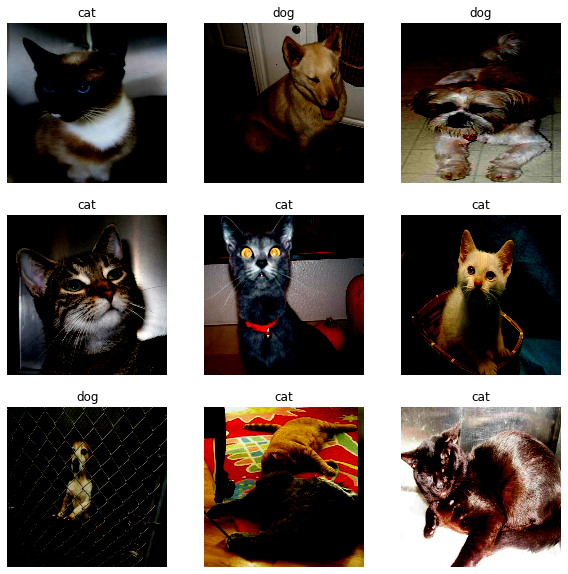

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(get_label_name(predictions[i]))
  plt.axis("off")